In [15]:
from lzma import LZMADecompressor, LZMAError, FORMAT_AUTO
import optparse
import os
import struct
from datetime import datetime, timedelta
from urllib import request
from urllib.error import HTTPError

# 3rd party modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


def decompress_lzma(data):
    results = []
    len(data)
    while True:
        decomp = LZMADecompressor(FORMAT_AUTO, None, None)
        try:
            res = decomp.decompress(data)
        except LZMAError:
            if results:
                break
            else:
                raise
        results.append(res)
        data = decomp.unused_data
        if not data:
            break
        if not decomp.eof:
            raise LZMAError("Compressed data ended before the end-of-stream marker was reached")
    return b"".join(results)


def tokenize(buffer):
    token_size = 20
    token_count = int(len(buffer) / token_size)
    tokens = list(map(lambda x: struct.unpack_from('>3I2f', buffer, token_size * x), range(0, token_count)))
    return tokens


def normalize_tick(symbol, day, time, ask, bid, ask_vol, bid_vol):
    date = day + timedelta(milliseconds=time)

    # TODO 網羅する。この通過ペア以外も有るかも
    if any(map(lambda x: x in symbol.lower(), ['usdrub', 'xagusd', 'xauusd', 'jpy'])):
        point = 1000
    else:
        point = 100000

    return [date, ask/point, bid/point, round(ask_vol * 1000000), round(bid_vol * 1000000)]


# 一日分のtickをDL(DL → decomp → tokenize → normalize)
def download_ticks(symbol, day):
    url_prefix='https://datafeed.dukascopy.com/datafeed'

    ticks_day = []
    for h in range(0, 24):
        file_name = f'{h:02d}h_ticks.bi5'
        url = f'{url_prefix}/{symbol}/{day.year:04d}/{day.month-1:02d}/{day.day:02d}/{file_name}'
        print(f'downloading: {url}')

        req = request.Request(url)
        try:
            with request.urlopen(req) as res:
                res_body = res.read()
        except HTTPError:
            print('download failed. continuing..')
            continue

        if len(res_body):
            try:
                data = decompress_lzma(res_body)
            except LZMAError:
                print('decompress failed. continuing..')
                continue
        else:
            data = []

        tokenized_data = tokenize(data)
        ticks_hour = list(map(lambda x: normalize_tick(symbol, day + timedelta(hours=h), *x), tokenized_data))
        ticks_day.extend(ticks_hour)

    return ticks_day


def format_to_csv_for_ticks(ticks):
    return '\n'.join(map(lambda x: '{},{},{},{},{}'.format(x[0].strftime('%Y-%m-%d %H:%M:%S.%f'), *x[1:]), ticks))+'\n'

In [28]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
        plt.show()
    return 

In [3]:
date = datetime.strptime('2024-06-28', '%Y-%m-%d')
ticks = download_ticks('EURUSD', date)
ticks_df = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
ticks_df.set_index('datetime', inplace=True)
mids = (ticks_df['ask'] + ticks_df['bid']) / 2

downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2024/05/28/00h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2024/05/28/01h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2024/05/28/02h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2024/05/28/03h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2024/05/28/04h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2024/05/28/05h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2024/05/28/06h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2024/05/28/07h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2024/05/28/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2024/05/28/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2024/05/28/10h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2024/

freq: 100ms
Log Returns:


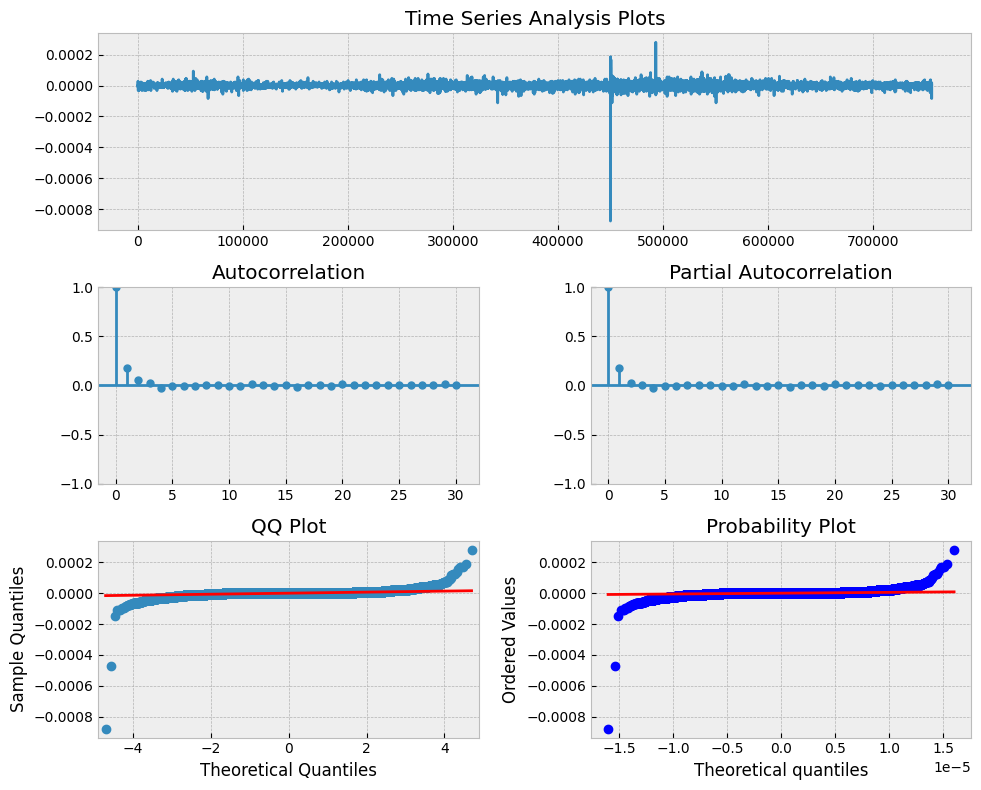

Pip Changes:


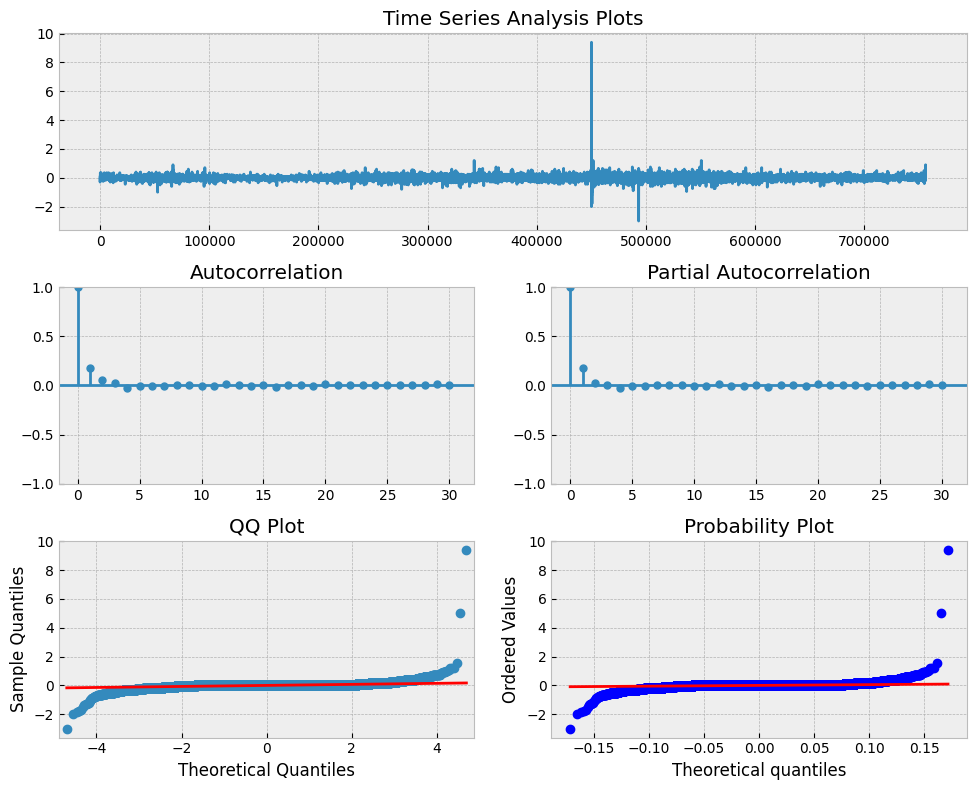

freq: 200ms
Log Returns:


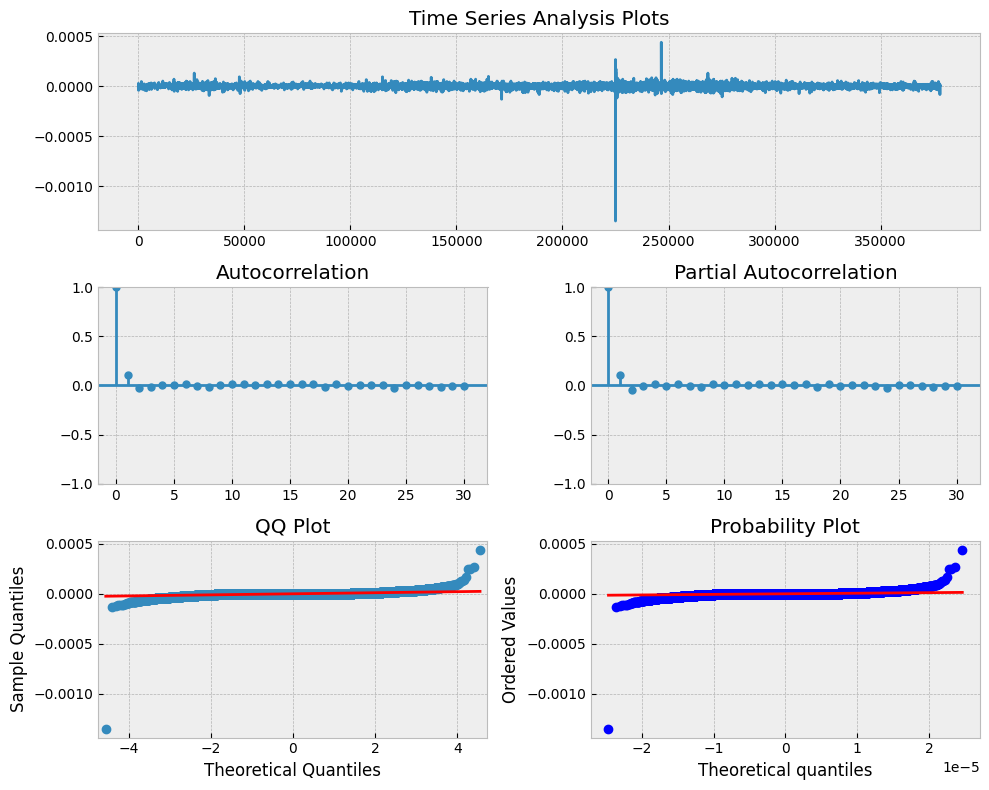

Pip Changes:


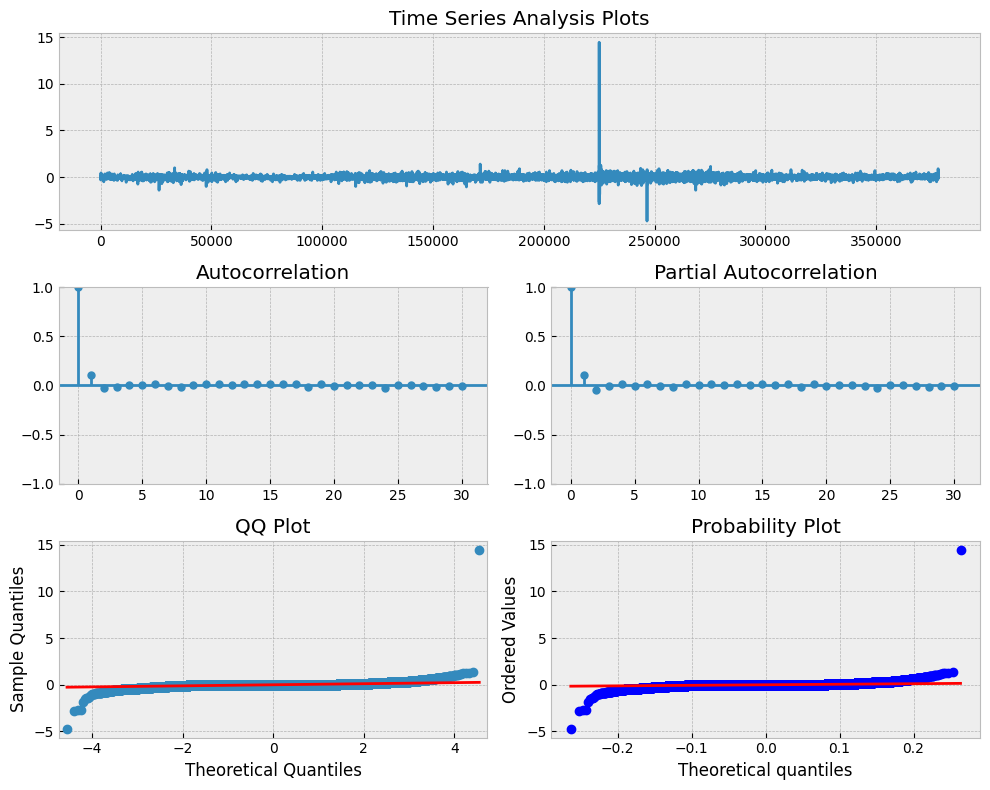

freq: 500ms
Log Returns:


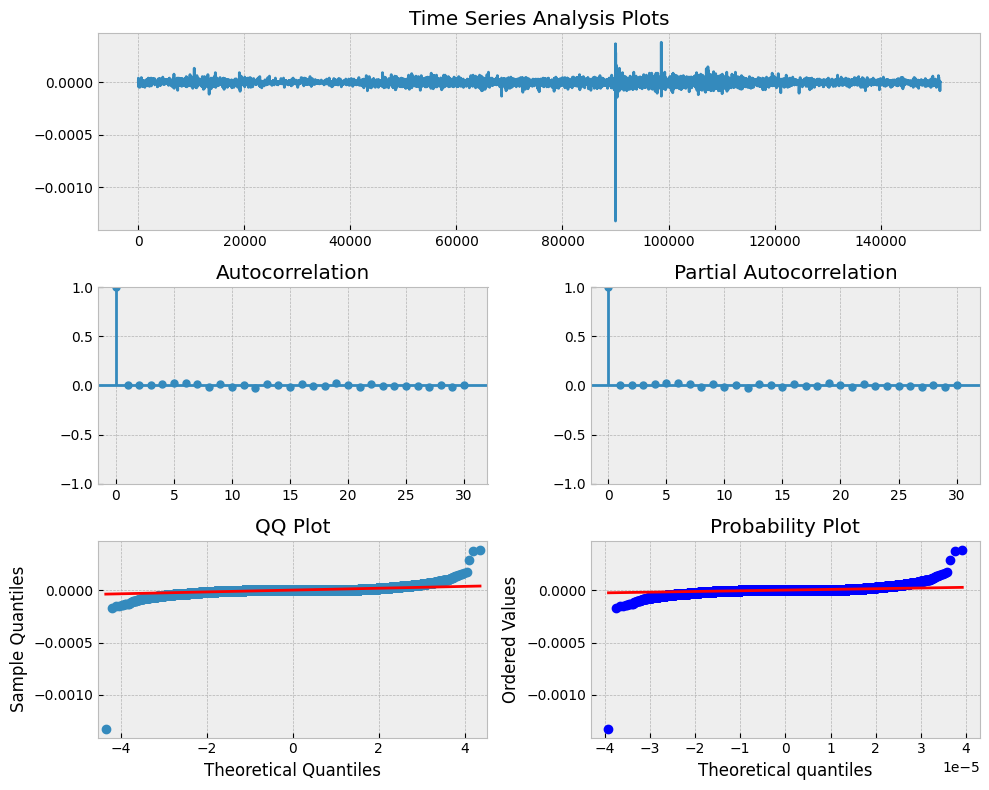

Pip Changes:


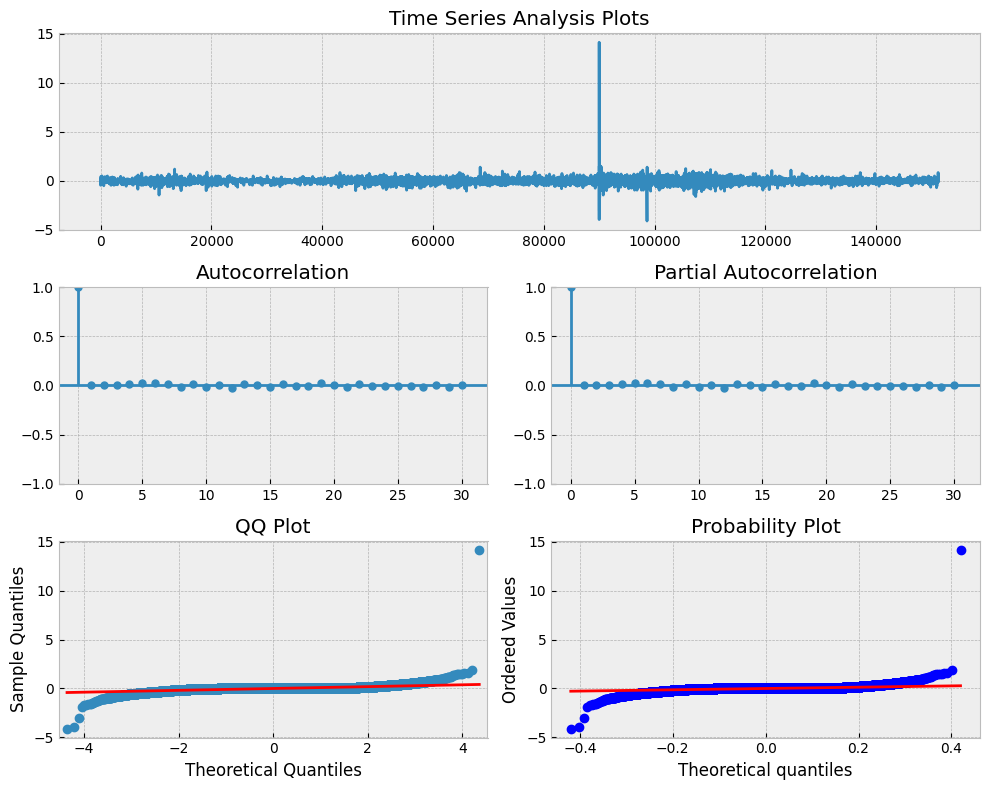

freq: 1s
Log Returns:


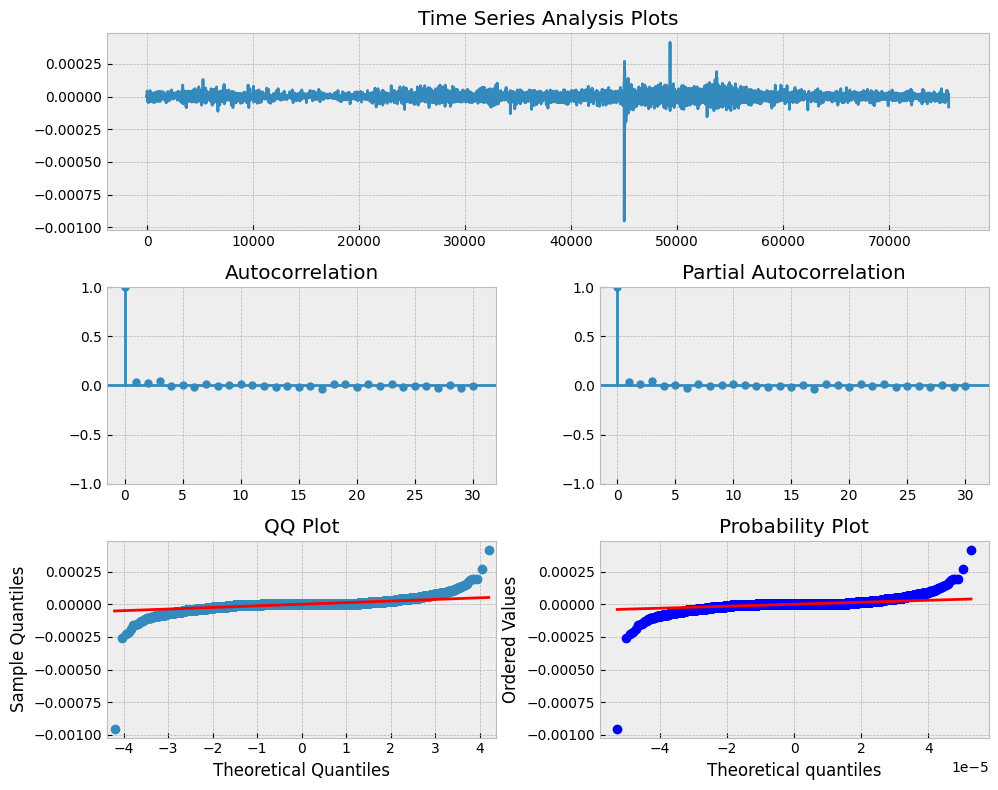

Pip Changes:


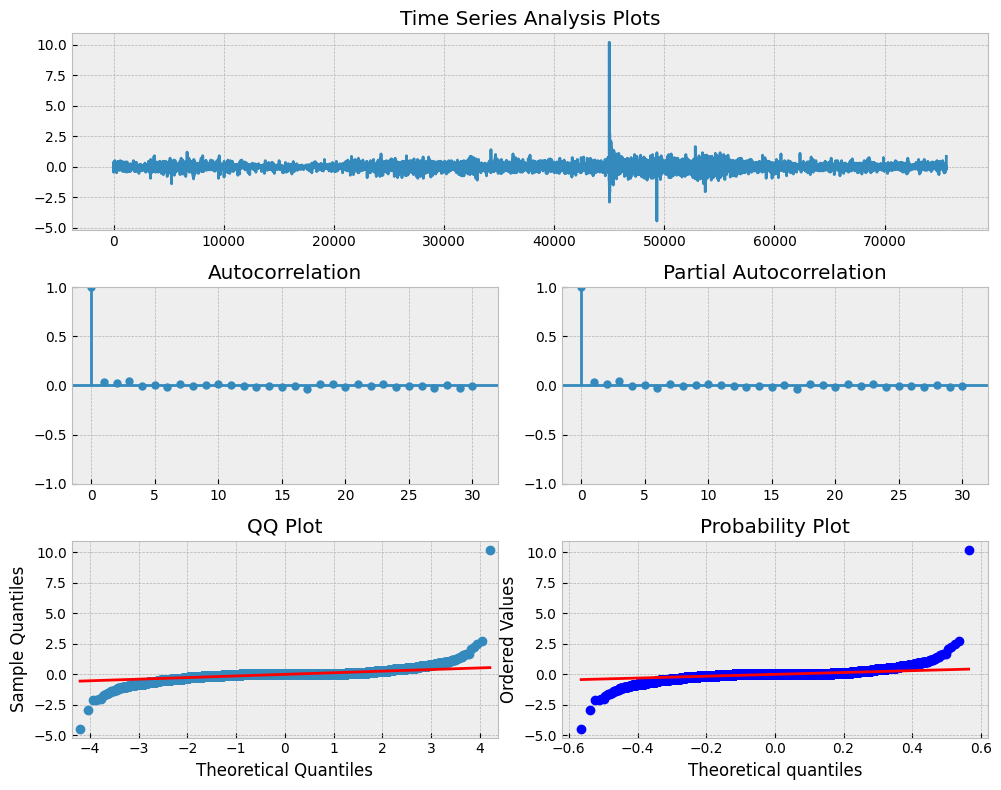

freq: 5s
Log Returns:


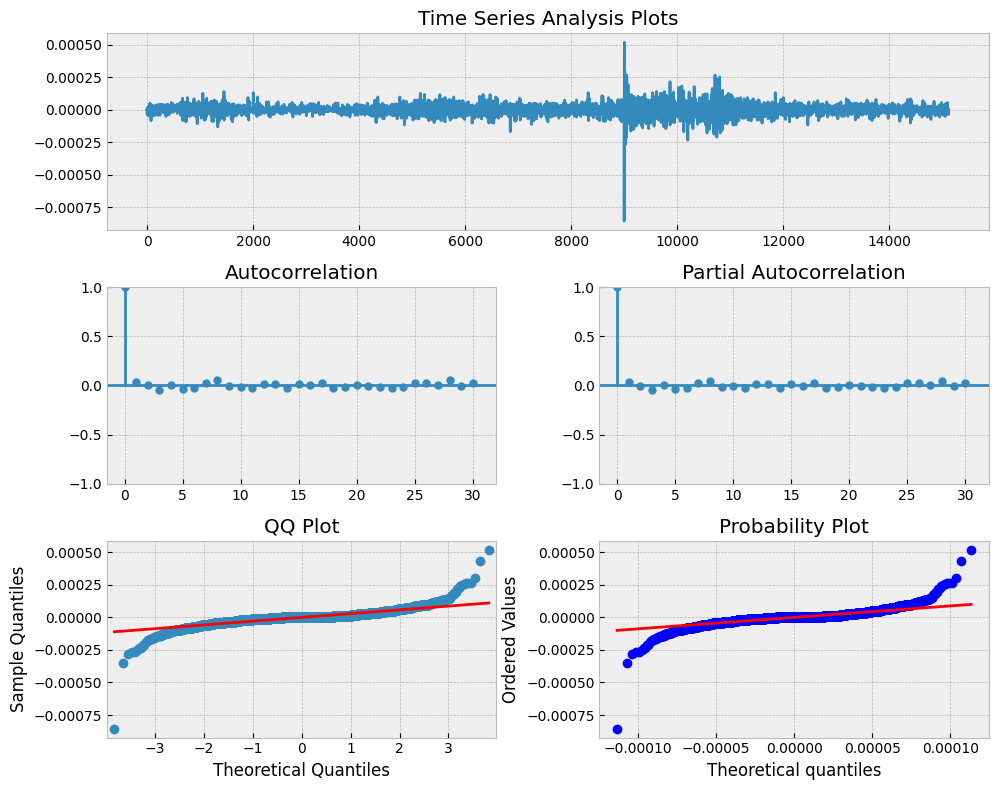

Pip Changes:


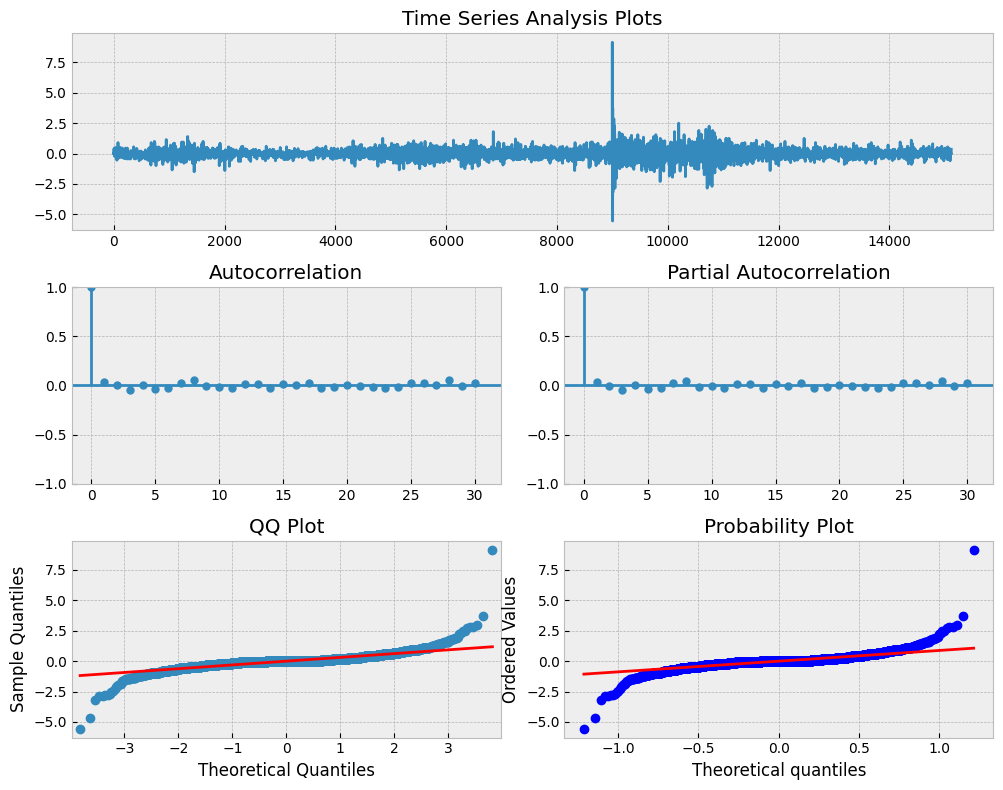

freq: 10s
Log Returns:


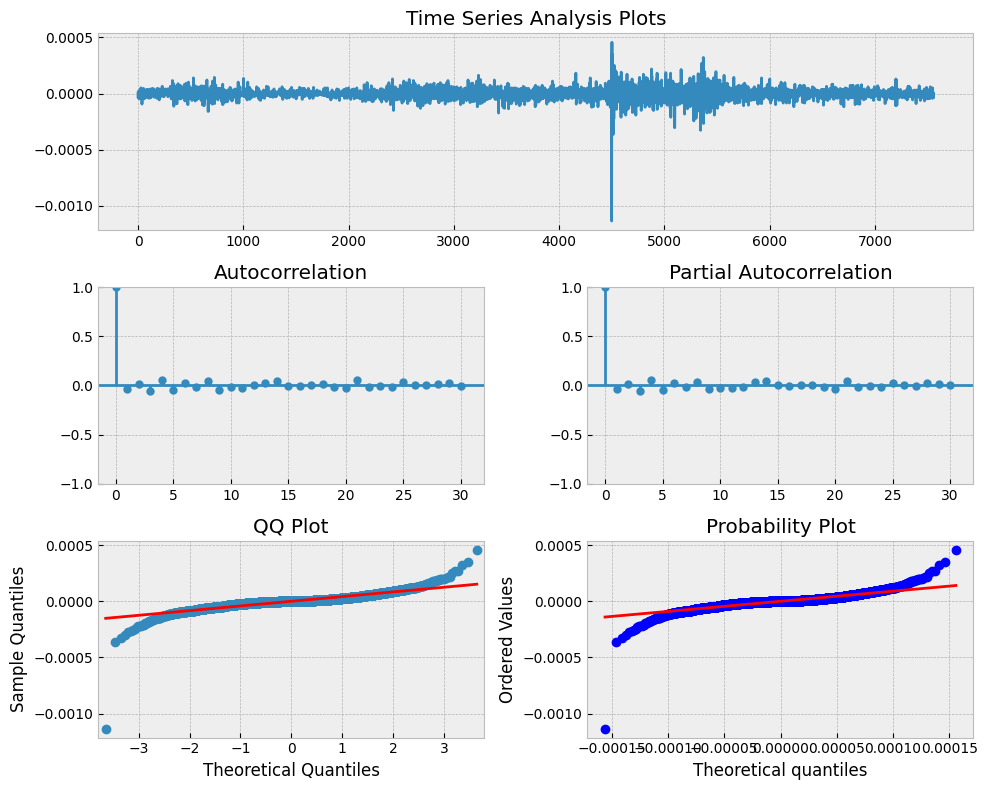

Pip Changes:


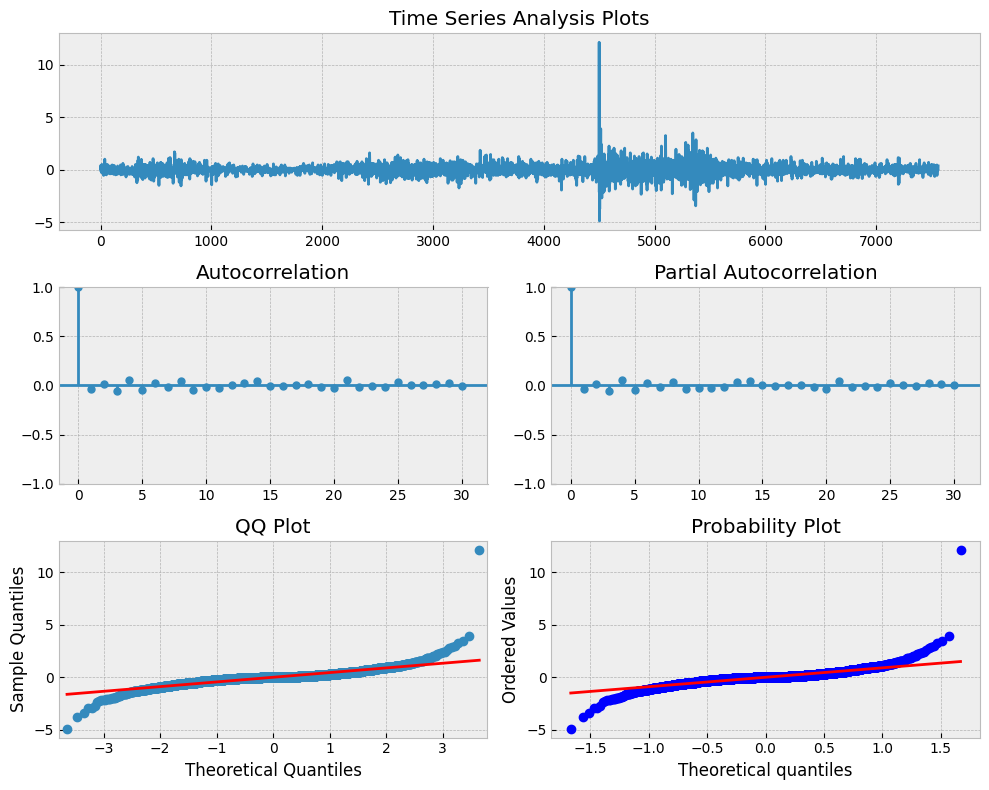

freq: 30s
Log Returns:


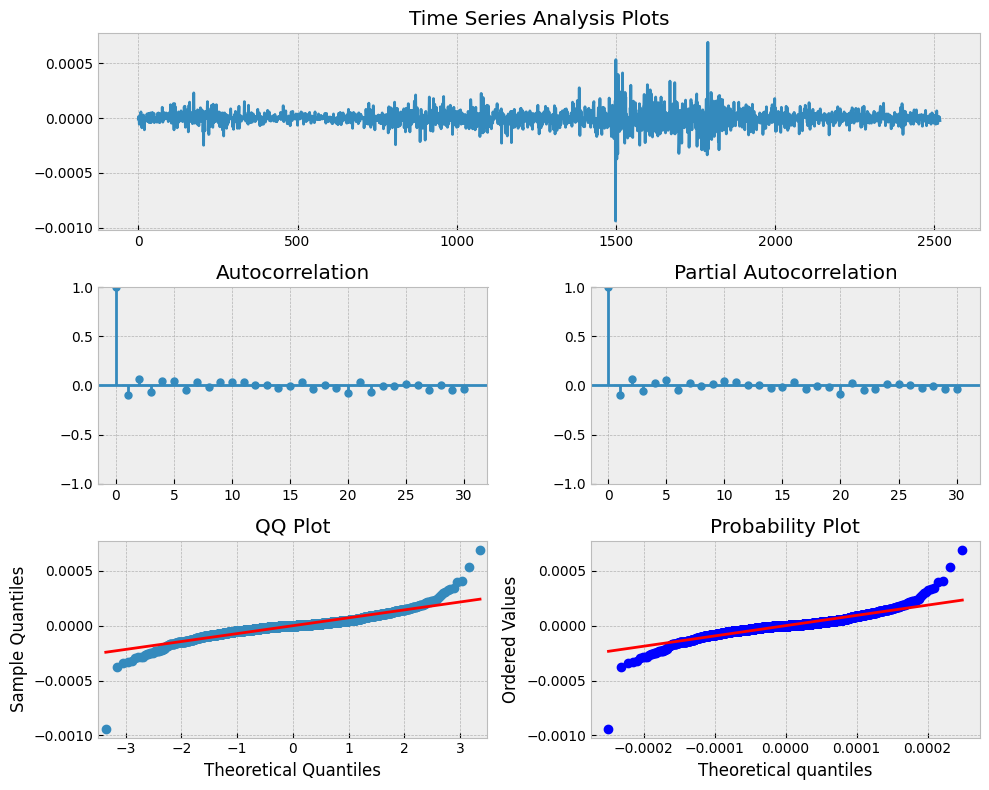

Pip Changes:


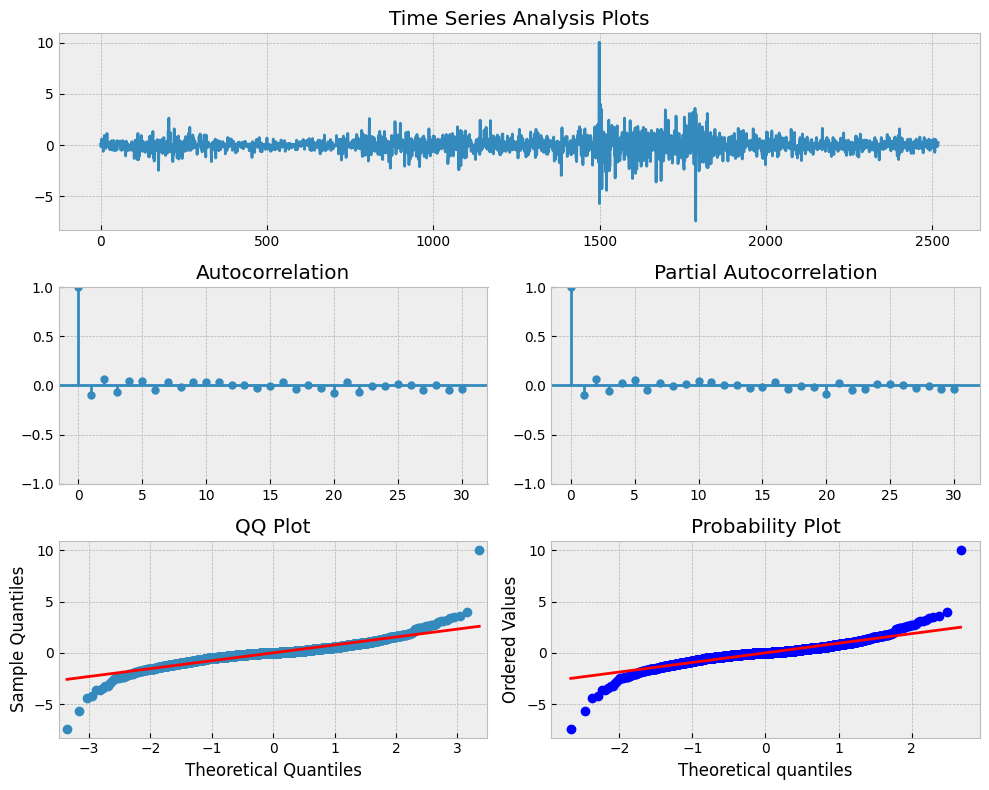

freq: 1min
Log Returns:


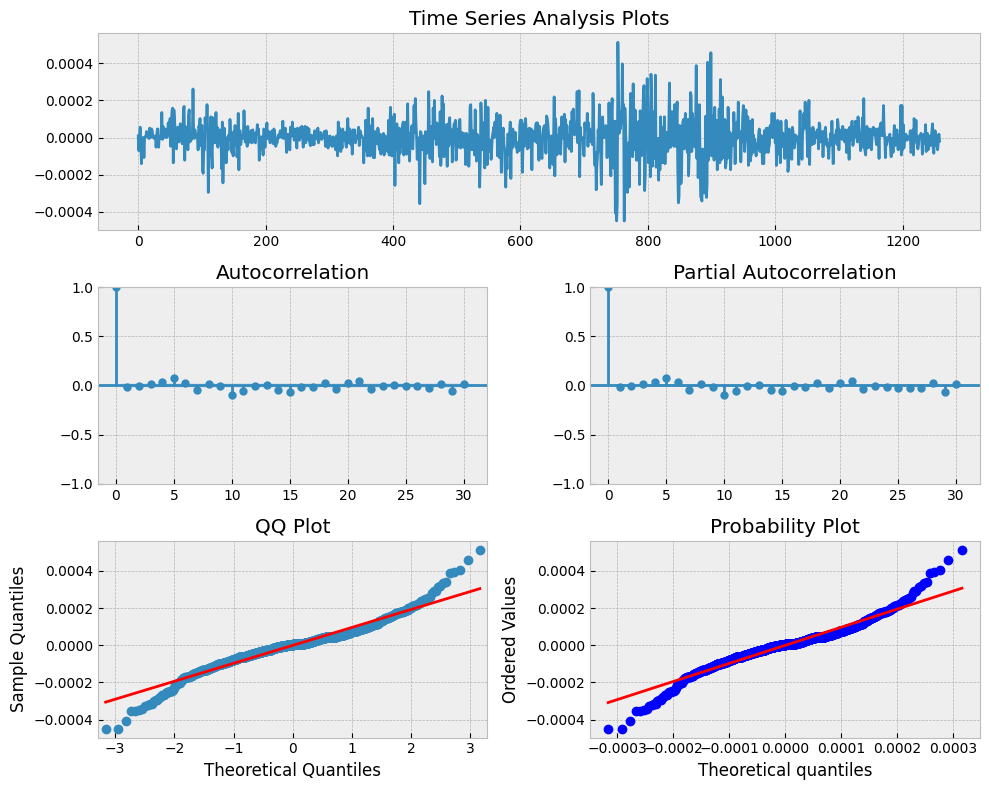

Pip Changes:


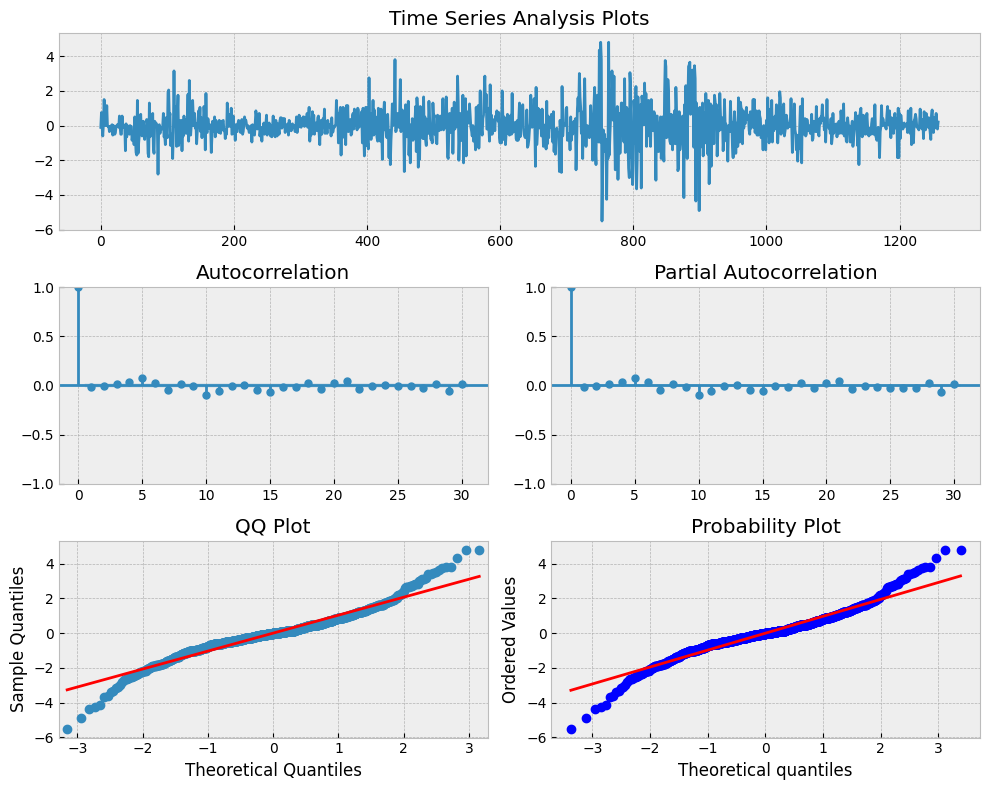

freq: 5min
Log Returns:


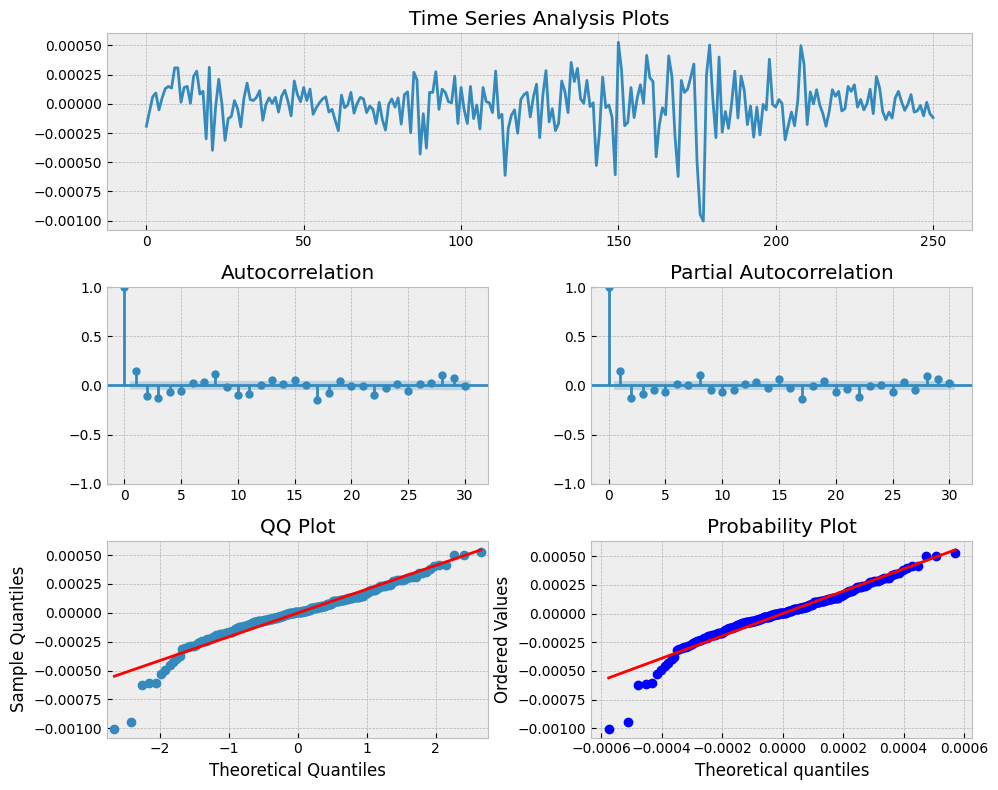

Pip Changes:


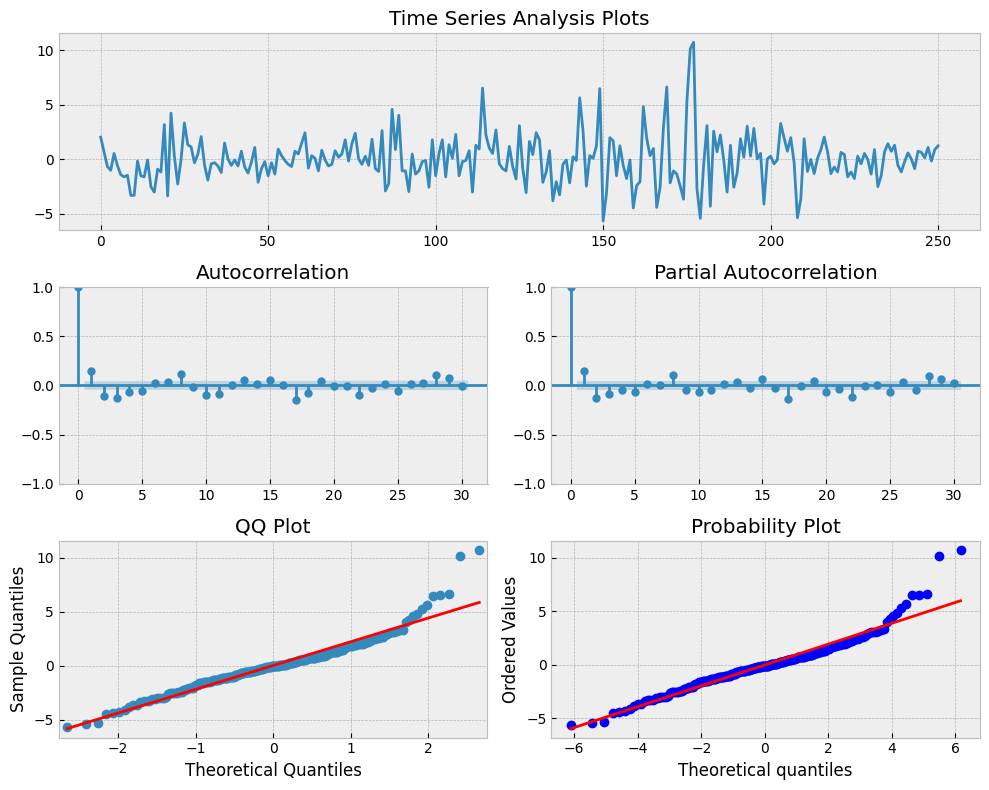

freq: 15min
Log Returns:


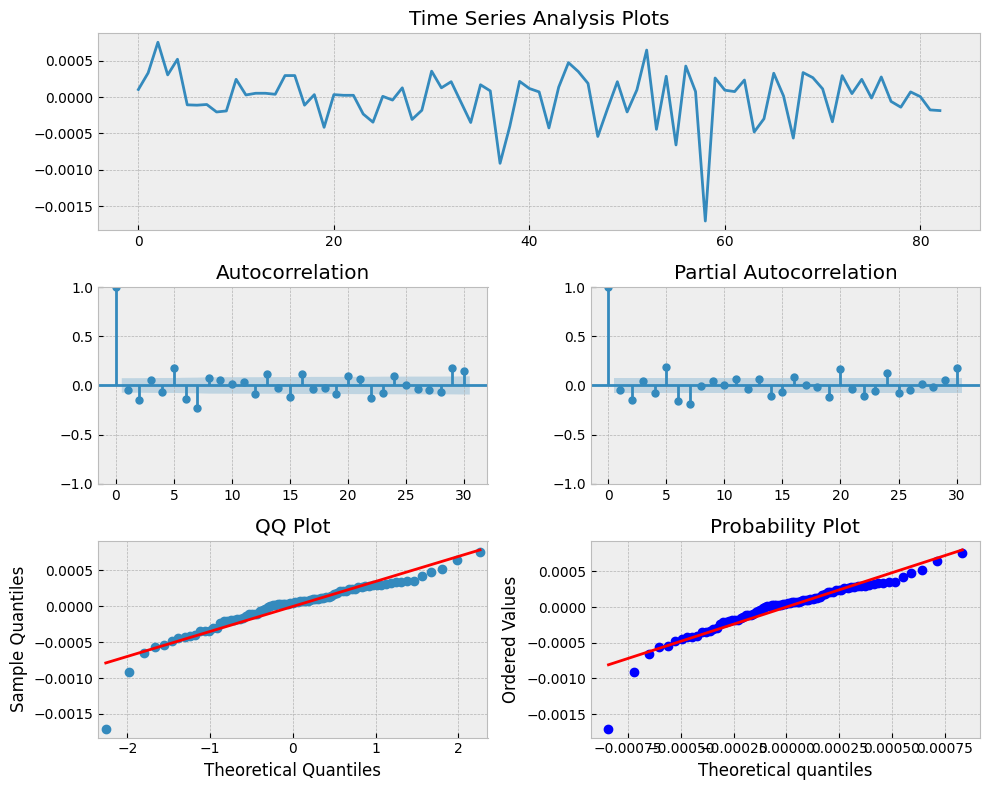

Pip Changes:


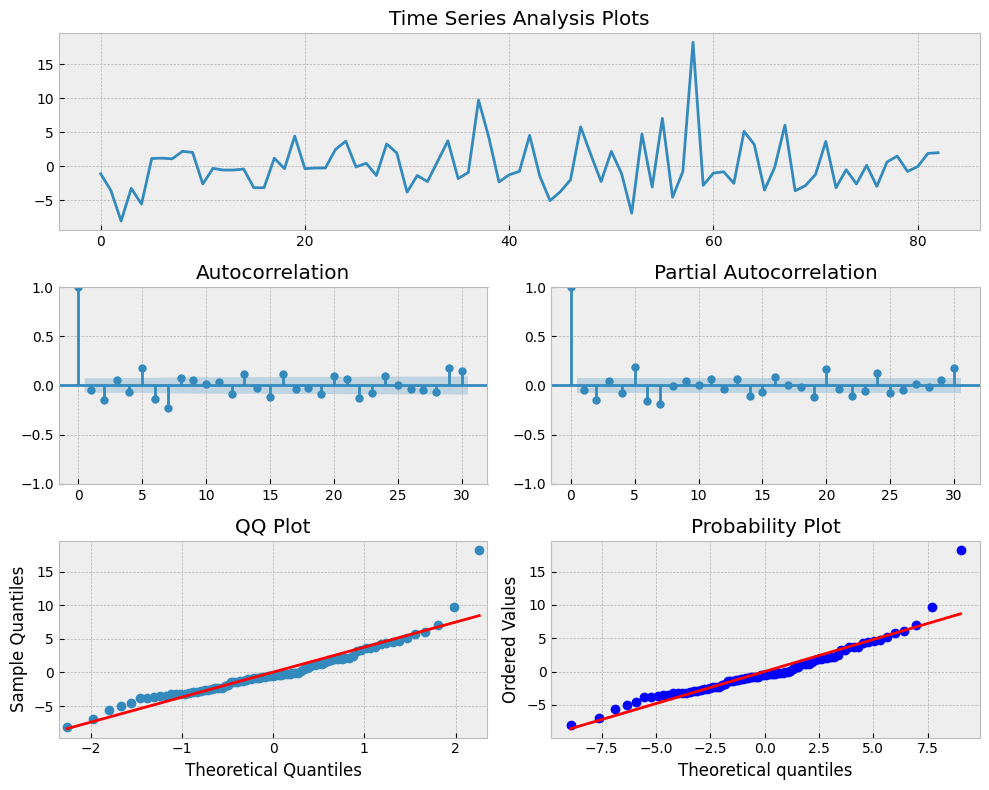

In [29]:
freqs = ['100ms', '200ms', '500ms', '1s', '5s', '10s', '30s', '1min', '5min', '15min']
for freq in freqs:
    print(f'freq: {freq}')
    last = mids.resample(freq).ohlc()['close'].ffill().to_numpy()
    print('Log Returns:')
    log_rets = np.log(last[:-1]) - np.log(last[1:])
    tsplot(log_rets, lags=30)
    pip_chngs = np.diff(last) * 10000
    print('Pip Changes:')
    tsplot(pip_chngs, lags=30)

In [34]:
from scipy.stats import kurtosis, skew
from statsmodels.stats.diagnostic import lilliefors
freqs = ['100ms', '200ms', '500ms', '1s', '5s', '10s', '30s', '1min', '5min', '15min']
for freq in freqs:
    print(f'freq: {freq}')
    last = mids.resample(freq).ohlc()['close'].ffill().to_numpy()
    print('Log Returns:')
    log_rets = np.log(last[:-1]) - np.log(last[1:])
    print(skew(log_rets), kurtosis(log_rets), lilliefors(log_rets))
    pip_chngs = np.diff(last) * 10000
    print('Pip Changes:')
    print(skew(pip_chngs), kurtosis(pip_chngs), lilliefors(pip_chngs))

freq: 100ms
Log Returns:
-25.698157831247634 6865.805439037899 (0.4524322475140711, 0.0009999999999998899)
Pip Changes:
25.721700858023205 6874.138635245511 (0.4524322984284494, 0.0009999999999998899)
freq: 200ms
Log Returns:
-40.79825470807446 11182.186777900093 (0.4248175217650869, 0.0009999999999998899)
Pip Changes:
40.81977342972456 11188.221402571282 (0.42481745565127865, 0.0009999999999998899)
freq: 500ms
Log Returns:
-20.748393234617843 3392.380840995307 (0.37503894026943363, 0.0009999999999998899)
Pip Changes:
20.75876795618106 3394.261971493107 (0.3750388432962591, 0.0009999999999998899)
freq: 1s
Log Returns:
-5.470198292244579 521.4555225644056 (0.3176624865845368, 0.0009999999999998899)
Pip Changes:
5.476766237675721 522.0535522675802 (0.3176623514622708, 0.0009999999999998899)
freq: 5s
Log Returns:
-1.1651325685637113 71.71092353583296 (0.18070950042683157, 0.0009999999999998899)
Pip Changes:
1.1657507297420346 71.83449660152309 (0.1809375281698291, 0.0009999999999998899)
f

In [22]:
tsplot(log_rets, lags=30)

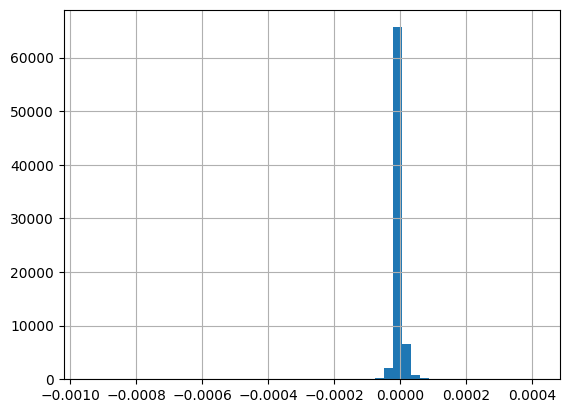

In [27]:
pd.Series(log_rets).hist(bins=50)
plt.show()

In [30]:
plt.show()